In [246]:
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader

In [247]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [248]:
df = pd.read_csv("dataset.csv")
print(df.head())
print(df.info())
print(len(df))


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
50000


convert reviews(text) to tokens
convert sentiment to digit - positive = 1, negative = 0

In [249]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [250]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
class MovieDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['review'].values
        self.labels = dataframe['sentiment'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):

        token_ids = tokenizer.encode(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            max_length=256,
            padding='max_length'
        )
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


dataset = MovieDataset(df)

In [251]:
from torch.utils.data import random_split

total_len = len(dataset)
train_len = int(0.8 * total_len)
valid_len = int(0.1 * total_len)
test_len  = total_len - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_len, valid_len, test_len])


In [252]:
print(train_dataset[0])

(tensor([  101,  1045,  3062,  1999,  2293,  2007,  2023,  4333,  2895,  3689,
         1012,  9679,  5735,  1998,  2069,  9679,  5735,  2071,  2031,  2209,
         2023,  2061,  2092,  1012,  2992,  2013,  5593,  2000,  2113,  2498,
         2021,  2162,  1998,  3554,  1010,  6927,  1006,  9679,  5735,  1007,
         2003, 14019,  2006,  1037,  4774,  2044,  2108,  2081, 15832,  2011,
        19345, 13685,  3548,  1012,  1026,  7987,  1013,  1028,  1026,  7987,
         1013,  1028,  1996,  2754,  2003,  2275,  1998,  2178,  4438, 12696,
         1997,  2895,  5691,  2001,  2141,  1011,  5268,  1012,  2025,  8223,
         5092,  1010,  2025, 29058,  8625, 13327,  1010,  2025,  5503, 12688,
         1010,  2025, 11463,  9406,  1010,  2025,  4463, 28093,  3511,  1011,
         9679,  5735,  8617,  2023,  2535,  1998,  2081,  2009,  4498,  2010,
         1011,  2434,  1010, 15236,  1010,  1998,  2035,  2205,  2529,  1012,
         1045,  3335,  1996,  2755,  2008, 25815,  2020,  2196,

In [253]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

40000 5000 5000


In [254]:

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

for batch in train_loader:
    inputs, labels = batch
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([128, 256])
torch.Size([128])


In [255]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList( 
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)


        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [256]:
vocab_size = tokenizer.vocab_size
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 2
dropout_rate = 0.5
pad_index = tokenizer.pad_token_id
CNNModel = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout_rate, pad_index)

In [257]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(CNNModel):,} trainable parameters")

The model has 9,517,502 trainable parameters


In [258]:
def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.uniform_(m.weight, -0.1, 0.1)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

CNNModel.apply(init_weights)


CNN(
  (embedding): Embedding(30522, 300, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [259]:
import torch.optim as optim
optimizer = optim.Adam(CNNModel.parameters())
loss_fn = nn.CrossEntropyLoss()

In [260]:
CNNModel = CNNModel.to(device)
loss_fn = loss_fn.to(device)

In [261]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [262]:
import tqdm
import numpy as np
import torch

def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch_ids, batch_labels in tqdm.tqdm(data_loader, desc="training..."):  # unpack tuple
        batch_ids = batch_ids.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        prediction = model(batch_ids)
        loss = criterion(prediction, batch_labels)

        # calculate accuracy
        accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [263]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch_ids, batch_labels in tqdm.tqdm(data_loader, desc="evaluating..."):  # unpack tuple
            batch_ids = batch_ids.to(device)
            batch_labels = batch_labels.to(device)

            prediction = model(batch_ids)
            loss = criterion(prediction, batch_labels)

            # calculate accuracy
            accuracy = (prediction.argmax(dim=1) == batch_labels).float().mean()

            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [264]:
import collections
import torch

n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

CNNModel = CNNModel.to(device)  # move model to GPU/CPU

for epoch in range(n_epochs):
    train_loss, train_acc = train(train_loader, CNNModel, loss_fn, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_loader, CNNModel, loss_fn, device)

    # store metrics
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)

    # save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(CNNModel.state_dict(), "cnn.pt")

    print(f"Epoch: {epoch+1}")
    print(f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}")
    print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f}")


evaluating...: 100%|██████████| 40/40 [00:09<00:00,  4.37it/s]


Epoch: 1
Train Loss: 0.580, Train Acc: 0.676
Valid Loss: 0.382, Valid Acc: 0.828


evaluating...: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


Epoch: 2
Train Loss: 0.358, Train Acc: 0.840
Valid Loss: 0.311, Valid Acc: 0.864


evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]

Epoch: 3
Train Loss: 0.283, Train Acc: 0.883
Valid Loss: 0.302, Valid Acc: 0.873


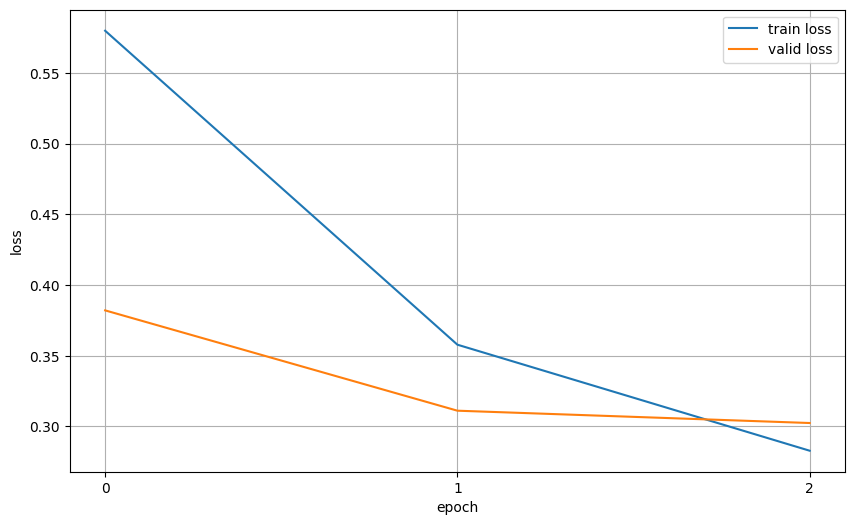

In [265]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

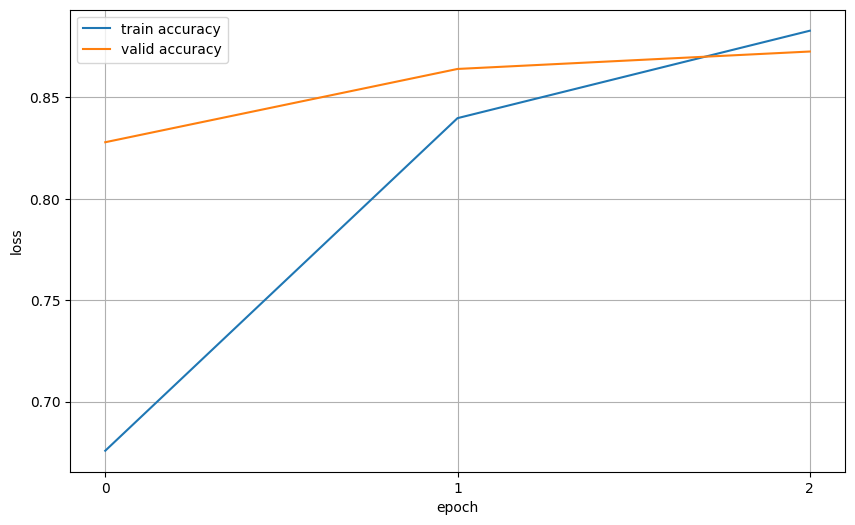

In [266]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [267]:
test_loss, test_acc = evaluate(test_loader, CNNModel, loss_fn, device)
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")


evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]

test_loss: 0.291, test_acc: 0.880


In [268]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    
    # Tokenize and pad
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,
        padding='max_length',
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)  # [1, seq_len]

    # Get model prediction
    with torch.no_grad():
        prediction = model(input_ids)  # [1, output_dim]
        probs = torch.softmax(prediction, dim=-1)
        predicted_class = prediction.argmax(dim=-1).item()
        predicted_prob = probs[0, predicted_class].item()
    
    return predicted_class, predicted_prob

In [269]:
text = "This film is very boring and waste of time!"
min_length = max(filter_sizes)

predict_sentiment(text, CNNModel, tokenizer, device, pad_index)

(0, 0.9994163513183594)

10 epochs, adamn, cross entropy loss, no initializing weights,embedding dim 128, drop out rate - 0.5, max len 128 - 80% test accuracy

10 epochs, adam, cross entropy loss, initializing weights, emb dim 128, drop out tate - 0.5, max len 128  - 82% (validation loss increases)

10 epochs,adam,cross,init weights, emb dim 300, drp out rate - 0.5,max len = 256  - 86%
same as above, but stopping at 3 epochs - 88%, loss - 29%


Increase dropout slightly (e.g. 0.5 → 0.6) → sometimes reduces overfitting.

Use early stopping → stop training when validation loss stops improving.

Add weight decay (L2 regularization) in optimizer.

Use pretrained embeddings (GloVe) → better generalization than random embeddings.